# **MIDAS IIITD - Task 2 Part 1**

#### **Introduction**

For task one, the given dataset has been used to train a CNN network. A brief dataset description is given below:

*   Contains 62 classes.
*   This includes handwritten digits 0-9, alphabets A-Z and lowercase alphabets a-z.

This notebook only contains part one of the task. Other parts are in subsequent notebooks.

#### **Preprocessing**

1.   All images are of shape (900,1200,3) by default.
2.   Their is no data imbalance.

Following steps are taken for preprocessing.

1. Reduce image to 2 Dimensional image using Pillow. (900, 1200, 1)
2. Reduce size of image by rescaling to (128, 128).
3. Normalize image between 0-1 by dividing by 255.

#### **Data Augmentation**

1. Random Rotation - 10 Degrees
2. Feature Normalization


#### **Model and Training Details**

1.   Simple Data Augmentation was applied due to the low count of images.
2.   A simple Conv 2D network was defined for the model. It consists of 3 convolution blocks of 2 convolutional layers each. They have varying filter sizes which reduce as we go deeper in the model. This is to compensate for the stride which downsamples the image.
3.  This also enables the model to better learn features from windows of different sizes.
4. Categorical Cross Entropy is used as the loss function and Adam optimizer is used. Furthermore, ModelCheckpoints are added to:

    *   Save only the best model.
    *   Stop learning if the loss stagnates.
    *   Change learning rate of the model on the fly

**Latest model checkpoint for this part is stored as models/best.h5.**


# **Libraries Installed**

In [1]:
'''
Libraries required to run the code.
Development was done on Google Colab and hence it is preferable to run on Colab with GPU for faster setup.
'''

import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import os
from collections import Counter
import pickle
import tensorflow as tf
import keras
from  matplotlib import pyplot as plt
from PIL import Image
import gc
import pydot
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, BatchNormalization
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.constraints import maxnorm
from keras.utils.vis_utils import plot_model

# **Data Loading and Preprocessing**

In [11]:
# Data stores the Numpy Array while Category is the class.

data = []
category = []

In [12]:
'''
Helper Function to:
1. Load all Images as Numpy Arrays
'''

'''
Preprocessing:
1. Convert 3D image to 1D image to reduce computations.
2. Normalize between 0 and 1.
3. Keep data type as Float32.
4. Resize using pillow image library. Resize to (128,128) to improve speed.
'''

img_folder = 'train'

def load_data(img_folder):

    for dir1 in tqdm(os.listdir(img_folder)):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            pilload = Image.open(image_path).convert('L')
            pilload = pilload.resize((128,128))
            image= np.array(pilload)
            image = image.astype('float32')
            image /= 255  
            data.append(image)
            category.append(dir1)
            pilload.close()

In [13]:
'''
Loading Dataset using function.
'''

load_data(img_folder)

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:35<00:00,  1.77it/s]


In [14]:
'''
Create target dictionary
'''

target_dict={k: v for v, k in enumerate(np.unique(category))}
target_val=  [target_dict[category[i]] for i in range(len(category))]

# **EDA**

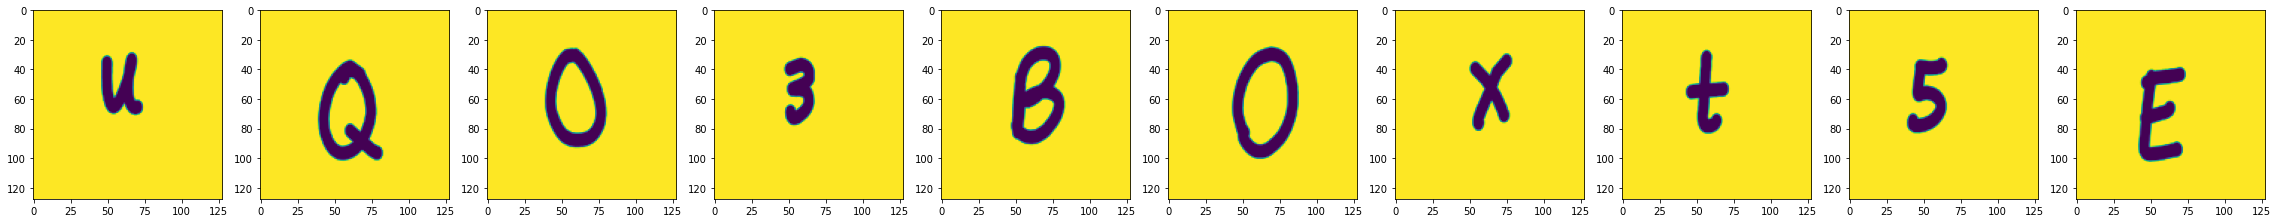

In [15]:
'''
Loading Sample Images
All images are upright and squared. No image rotation and flipping required.
'''

plt.figure(figsize=(40,20))

for i in range(10):
    image = random.choice(data)
    ax=plt.subplot(1,10,i+1)
    plt.imshow(image)

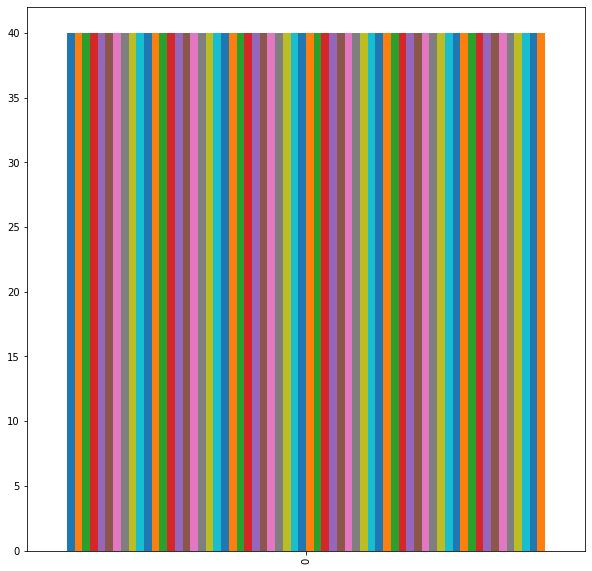

In [16]:
'''
Checking for data imbalance.
'''

d = Counter(target_val)
key = d.keys()

df = pd.DataFrame(d,index=key)
df.drop(df.columns[1:], inplace=True)
df.plot(kind='bar', legend = False, figsize=(10, 10), width = 3)

plt.show()

## Data Augmentation Vis and Define

In [56]:
'''
Defining Training Data and splitting
'''

X = np.array(data, np.float32).reshape(2480,128,128,1)
Y = tf.keras.utils.to_categorical(target_val, 62)

##### Feature Normalization

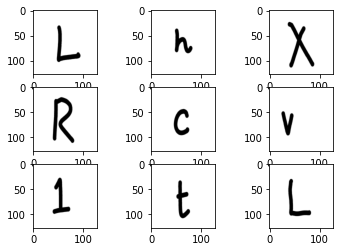

In [23]:
'''
1. Standardize pixel values across the entire dataset.
'''

vis_datagen1 = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
vis_datagen1.fit(X_train)

# Configure batch size and retrieve one batch of images.
for X_batch, Y_batch in vis_datagen1.flow(X_train, Y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(128, 128), cmap=plt.get_cmap('gray'))
    plt.show()
    break

##### Random Rotations

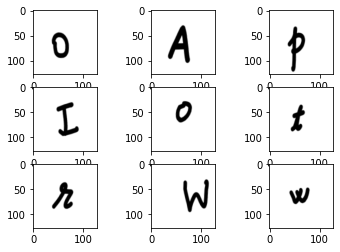

In [37]:
'''
Random 10 degree rotation.

1. Rotates randomly, images by 10 degrees.
2. Useful for images that might be tilted naturally while written.
'''

vis_datagen2 = ImageDataGenerator(rotation_range=10)
vis_datagen2.fit(X_train)

# Configure batch size and retrieve one batch of images.
for X_batch, Y_batch in vis_datagen2.flow(X_train, Y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(128, 128), cmap=plt.get_cmap('gray'))
    plt.show()
    break

# **Building And Training Model**

In [2]:
'''
The entire data is fed to a Tensorflow Keras based CNN network as described below.
'''

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=16, kernel_size=(5,5), strides=2, activation='relu', input_shape=(128,128,1)))
model.add(BatchNormalization())
model.add(keras.layers.Conv2D(filters=16, kernel_size=(5,5), strides=2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3) , strides=2, activation='relu'))
model.add(BatchNormalization())
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
model.add(BatchNormalization())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(units=62, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        416       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 16)        6416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 32)          1

In [118]:
'''
Setup DataGen
'''

datagen = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    rotation_range = 10
)

datagen.fit(X_train)
train_generator = datagen.flow(X_train, Y_train, batch_size = 20)

In [119]:
'''
Adding Callback API's to save best weights and change learning rate on the fly
'''
 
MCP = ModelCheckpoint('/content/drive/MyDrive/MIDAS TASK 2/best.h5', verbose=1, save_best_only=True, monitor='accuracy', mode='max')
ES = EarlyStopping(monitor='accuracy', min_delta=0, verbose=0, restore_best_weights = True, patience=3, mode='max')
RLP = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2, min_lr=0.0001)

In [120]:
%%time

'''
Training while also calculating time
'''

tf.config.run_functions_eagerly(False)

history = model.fit_generator(generator=train_generator,
                    epochs = 25, callbacks=[MCP,ES,RLP])

Epoch 1/25
112/112 [==============================] - 9s 72ms/step - loss: 4.3016 - accuracy: 0.0331

Epoch 00001: accuracy improved from -inf to 0.05690, saving model to /content/drive/MyDrive/MIDAS TASK 2\best.h5
Epoch 2/25
112/112 [==============================] - 9s 77ms/step - loss: 3.3254 - accuracy: 0.1815

Epoch 00002: accuracy improved from 0.05690 to 0.19489, saving model to /content/drive/MyDrive/MIDAS TASK 2\best.h5
Epoch 3/25
112/112 [==============================] - 9s 79ms/step - loss: 2.4170 - accuracy: 0.3498

Epoch 00003: accuracy improved from 0.19489 to 0.35797, saving model to /content/drive/MyDrive/MIDAS TASK 2\best.h5
Epoch 4/25
112/112 [==============================] - 8s 75ms/step - loss: 1.9383 - accuracy: 0.4680

Epoch 00004: accuracy improved from 0.35797 to 0.47133, saving model to /content/drive/MyDrive/MIDAS TASK 2\best.h5
Epoch 5/25
112/112 [==============================] - 8s 75ms/step - loss: 1.4809 - accuracy: 0.5840

Epoch 00005: accuracy improve

# **Training Analysis**

#### **Final Training Results**

1.   Accuracy - 90.457%
2.   Time = 3 min 35s
3.   Loss = 0.2599 

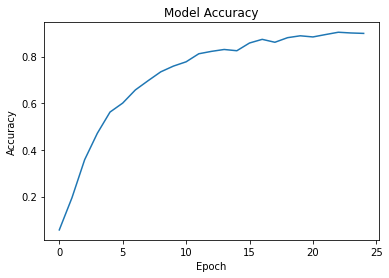

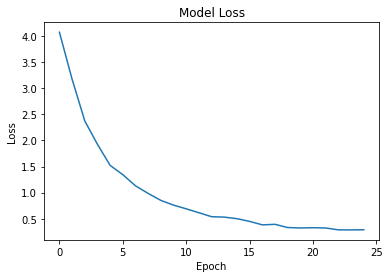

In [123]:
'''
Observing Training
'''

# accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [124]:
'''
Sample Testing. Will be tested when test data provided.
'''

# Load Model
model = keras.models.load_model('models/best.h5')

samples_ind = list(range(0, 2481))

for i in range(10):
    ind = random.choice(samples_ind)
    img = X[ind]
    ground_truth = Y[ind]
    print('Ground Truth:', np.argmax(ground_truth))

    prediction = model.predict(X[ind:ind + 1])
    print('Predicted Value:', np.argmax(prediction))

    print()

Ground Truth: 43
Predicted Value: 43

Ground Truth: 26
Predicted Value: 26

Ground Truth: 30
Predicted Value: 30

Ground Truth: 44
Predicted Value: 44

Ground Truth: 26
Predicted Value: 26

Ground Truth: 55
Predicted Value: 55

Ground Truth: 34
Predicted Value: 34

Ground Truth: 16
Predicted Value: 16

Ground Truth: 44
Predicted Value: 44

Ground Truth: 30
Predicted Value: 30

